# Figure 1H

Example of the data

In [1]:
import math
from pathlib import Path

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sb
from matplotlib import gridspec
from matplotlib import pyplot as plt

import analysis
from analysis import get_cells
from load import load_preprocessed_data

In [2]:
OUTPUT_DIR = Path('figures')

## Load data

In [3]:
session = 719334668

dff, data = load_preprocessed_data(session)

dff.index = dff.index.droplevel(["area", "cre", "session"])
data.index = data.index.droplevel(["area", "cre", "session"])
data["seconds"] = (data["t"] - pd.Timestamp(0)).dt.total_seconds()

## Select region

In [4]:
# Select region
start = 55128
end = 59231
subset = data.loc[start:end]

In [5]:
time = subset.loc[:, "seconds"]
t_start = time.loc[start]
t_end = time.loc[end]

run = subset.loc[:, "velocity"]

pupil = subset.loc[:, "normalized_pupil_diameter"]

stimuli = subset.loc[: ,"stimulus"]

example_dff = dff.loc[start:end, get_cells(dff)].values.transpose()

## Plot

In [6]:
path = OUTPUT_DIR / "fig-1/example_data"

In [7]:
matplotlib.rcParams.update(
    {
        "font.size": 12,
        "font.weight": "normal",
        "text.color": "black",
        "axes.labelcolor": "black",
        "xtick.color": "black",
        "ytick.color": "black",
    }
)

In [8]:
colormap = {
    "mouse montage 1, temporal phase scramble": "#56CCF2",
    "mouse montage 1, spatial phase scramble": "#2F80ED",
    "conspecifics": "#F2994A",
    "human montage": "#BB6BD9",
}

In [9]:
def get_hlines(stimulus):
    stimulus = stimulus.copy().fillna("interstimulus")
    transitions = stimulus.loc[stimulus.shift(1) != stimulus]
    stimuli = transitions.loc[transitions != "interstimulus"]
    starts = stimuli.index
    ends = transitions.loc[transitions == "interstimulus"].index
    if transitions.iloc[0] == "interstimulus":
        ends = ends[1:]
    if transitions.iloc[-1] != "interstimulus":
        ends = ends.append(stimulus.index[-1:])
    colors = transitions.loc[transitions != "interstimulus"].map(colormap)
    return starts.values, ends.values, colors.values, stimuli


def plot_stimuli(ax, starts, ends, colors, labels, y, **kwargs):
    ax.hlines(
        [0.5] * len(starts),
        starts,
        ends,
        colors=colors,
        linewidth=8,
    )
    x_coords = np.array([starts, ends]).mean(axis=0)
    for x, label in zip(x_coords, labels):
        ax.text(x, y, label, ha="center", **kwargs)
    return ax

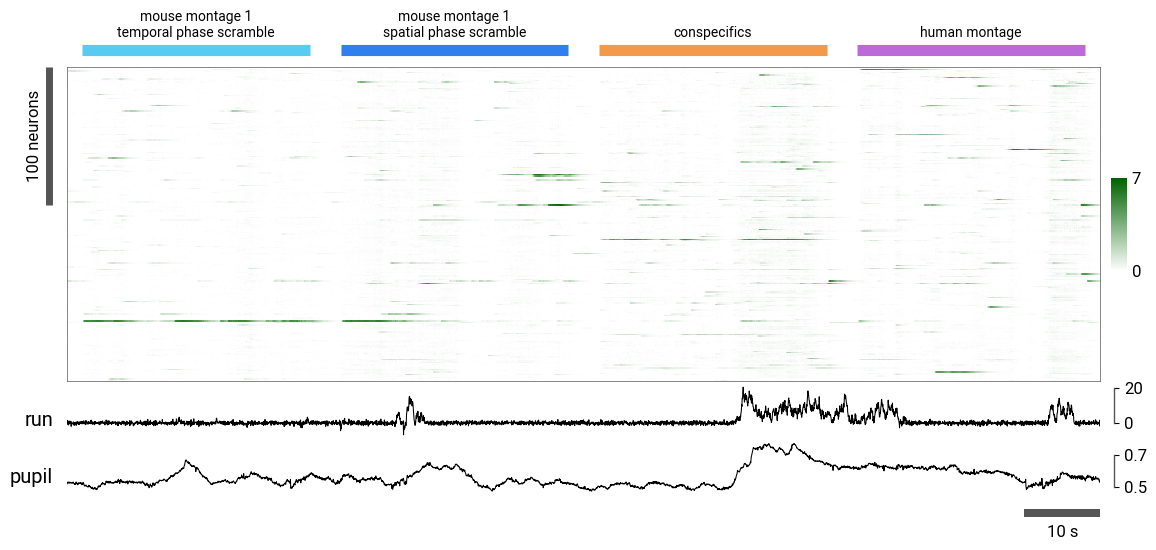

In [10]:
fig = plt.figure(figsize=(14, 6))

gs = matplotlib.gridspec.GridSpec(
    6,
    3,
    figure=fig,
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=0.03,
    hspace=0.05,
    width_ratios=[1 / 70, 1, 1 / 65],
    height_ratios=[1 / 12, 1, 1 / 6, 1 / 6, 1 / 40, 1 / 40],
)


# Stimuli
ax = stimuli_ax = plt.subplot(gs[0, 1])
starts, ends, colors, labels = get_hlines(stimuli)
labels = [label.replace(", ", "\n") for label in labels]
starts = time[starts].values
ends = time[ends].values
plot_stimuli(ax, starts, ends, colors, labels, 1, fontsize=10, fontweight="normal")
ax.set_ylim(0, 1)
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
ax.set_xlim(t_start, t_end)
for _, spine in ax.spines.items():
    spine.set_visible(False)

# dF/F
ax = dff_ax = plt.subplot(gs[1, 1], sharex=stimuli_ax)

cmap = sb.color_palette("blend:white,darkgreen", as_cmap=True)

vmax = math.ceil(example_dff.max())

image = ax.imshow(
    example_dff,
    interpolation="none",
    cmap=cmap,
    vmin=0,
    vmax=vmax,
    origin="lower",
    extent=[t_start, t_end, 0, example_dff.shape[0]],
    aspect="auto",
)
ax.grid(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color("#555")
    spine.set_linewidth(0.5)

# Number of cells scale
ax = plt.subplot(gs[1, 0], sharey=dff_ax)
ncells_scale = 100
ymax = example_dff.shape[0]
ymin = ymax - ncells_scale
ax.vlines(0, ymin, ymax, colors="#555", linewidth=5)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.text(
    -0.5,
    ymax - ncells_scale / 2,
    f"{ncells_scale} neurons",
    ha="center",
    va="center",
    rotation=90,
    transform=ax.get_yaxis_transform(),
)

# Time scale
ax = plt.subplot(gs[5, 1], sharex=dff_ax)
time_scale = 10
xmax = t_end
xmin = xmax - time_scale
ax.hlines(0.5, xmin, xmax, colors="#555", linewidth=10)
ax.set_ylim(0, 1)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.text(
    xmax - time_scale / 2,
    -2.0,
    f"{time_scale} s",
    ha="center",
    va="center",
    rotation=0,
    transform=ax.get_xaxis_transform(),
)

# Color bar
gs2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[1, 2])
ax = plt.subplot(gs2[1])
cb = fig.colorbar(image, use_gridspec=True, cax=ax)
cb.solids.set_edgecolor("face")
cb.outline.set_visible(False)
cb.set_ticks([0, vmax])
cb.ax.tick_params(length=0)

# Run
ax = plt.subplot(gs[2, 1], sharex=stimuli_ax)
sb.lineplot(x=time.values, y=run, ax=ax, color="black", linewidth=0.75)
ax.grid(False)
ax.xaxis.set_visible(False)
ax.set_ylabel("run", rotation=0, ha="right", va="top", labelpad=10, fontweight="normal")
ax.yaxis.tick_right()
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(True)
ax.spines["right"].set_position(("outward", 10))
ax.spines["right"].set_bounds(
    ax.get_yticks()[
        (ax.get_yticks() > ax.get_ylim()[0]) & (ax.get_yticks() < ax.get_ylim()[1])
    ]
)

# Pupil
ax = plt.subplot(gs[3, 1], sharex=stimuli_ax)
sb.lineplot(x=time.values, y=pupil, ax=ax, color="black", linewidth=0.75)
ax.grid(False)
ax.xaxis.set_visible(False)
ax.set_ylabel(
    "pupil", rotation=0, ha="right", va="top", labelpad=10, fontweight="normal"
)
ax.yaxis.tick_right()
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(True)
ax.spines["right"].set_position(("outward", 10))
yticks = [0.5, 0.7]
ax.set_yticks(yticks)
ax.spines["right"].set_bounds(yticks)

for suffix in [".png", ".svg"]:
    analysis.savefig(
        fig,
        path,
        suffix=suffix,
        facecolor=None,
        edgecolor=None,
    )